In [ ]:
# -----GENERAL-----
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

# -----FEATURES SELECTION-----
from sklearn.feature_selection import (SelectKBest, SelectFromModel, RFE, SequentialFeatureSelector,
                                       mutual_info_regression)
from sklearn.feature_selection import SequentialFeatureSelector

# -----PREPROCESING-----
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import boxcox
from sklearn.decomposition import PCA

# -----PIPELINE-----
from sklearn.pipeline import Pipeline

# -----MODELOS-----
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# -----ÁRBOLES-----
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# -----MÉTRICAS-----
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score

# ----CROSSVALIDATION-----
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# -----GUARDAR MODELOS-----
import pickle

# -----EVALUACIÓN DE MODELOS-----
import matplotlib.pyplot as plt



# Entrenamiento y evaluación
#### 1. [Featuring selection](#id1)
#### 2. [Decisión de modelo](#id2)
#### 3. [Elección de hiperparámetros](#id3)
#### 4. [Evaluación del modelo](#id4)

Antes de empezar con el entrenamiento, vamos a cargar los datos de train y test. También aplicaremos ahora la transformación de Box-Cox en el target.

In [2]:
# Carga de datos
train_set = pd.read_csv('../data/train/train_set.csv', index_col=0) 
test_set = pd.read_csv('../data/test/test_set.csv', index_col=0)   

# Aplicación de Box-Cox al target

train_set['target_boxcox'], lambda_opt = boxcox(train_set['target'])

X_train = train_set.drop(columns=['target','target_boxcox'])
y_train = train_set['target_boxcox']

test_set['target_boxcox'] = boxcox(test_set['target'], lambda_opt)

X_test = test_set.drop(columns=['target', 'target_boxcox'])
y_test = test_set['target_boxcox']

<div id='id1' />

## 1. Featuring selection
Para la selección de variables del modelo vamos a seleccionar las más importantes utilizando diferentes estrategias:
1. Análisis visual combinado con filtrado por valores de correlación.
2. Selección de features numéricas mediante SelectKBest y ANOVA, selección de features categóricas mediante Mutual Information
3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
4. Selección de las mejores features empleando RFE.
5. Selección de las mejores features empleando SFS.
6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.
7. Selección de variables transformadas mediante PCA. (MACHINE LEARNING NO SUPERVISADO)

### 2.1. Analisis por filtrado de valores de correlación
Como vimos en el EDA, todas las variables son de tipo numéricas. Seleccionaremos las 5 con más correlación con el target.

In [3]:
# Variables ordenadas por correlación
features_visual = train_set.corr()['target_boxcox'].abs().sort_values(ascending=False)
features_visual

target_boxcox            1.000000
target                   0.984910
carbon                   0.666429
cogeneracion             0.627023
ciclo_combinado          0.604171
exportacion_marruecos    0.391165
hidraulica               0.339953
solar_fotovoltaica       0.318900
importacion_portugal     0.306920
importacion_marruecos    0.296014
nuclear                  0.258868
eolica                   0.227885
exportacion_andorra      0.190677
exportacion_portugal     0.077253
exportacion_francia      0.053101
importacion_francia      0.038231
solar_termica            0.037377
importacion_andorra      0.034007
Name: target_boxcox, dtype: float64

In [4]:
# Cogemos las variables con correlación >0.3
features_visual = list(features_visual[2:8].index)
features_visual

['carbon',
 'cogeneracion',
 'ciclo_combinado',
 'exportacion_marruecos',
 'hidraulica',
 'solar_fotovoltaica']

### 2.2. Selección de features numéricas mediante SelectKBest y ANOVA, selección de features numéricas mediante mutual_info_regression

In [5]:
selector = SelectKBest(mutual_info_regression, k=6)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())

In [6]:
features_filter = list(selector.get_feature_names_out())
features_filter

['nuclear',
 'carbon',
 'ciclo_combinado',
 'hidraulica',
 'solar_fotovoltaica',
 'cogeneracion']

### 2.3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)

In [7]:
features = X_train.columns
rf_selector = RandomForestRegressor(random_state= 42)
selector_modelo = SelectFromModel(estimator = rf_selector, threshold= "median") # Nos quedamos con la mitad
selector_modelo.fit(X_train, y_train)
features_modelo = list(selector_modelo.get_feature_names_out())
features_modelo

['eolica',
 'nuclear',
 'carbon',
 'ciclo_combinado',
 'hidraulica',
 'solar_fotovoltaica',
 'cogeneracion',
 'importacion_portugal']

### 2.4. Selección de las mejores features empleando RFE.

In [8]:
rf_RFE = RandomForestRegressor(random_state= 42)
rfe = RFE(estimator = rf_RFE,
        n_features_to_select= 6, # Iterará hasta quedarse con 6
        step = 1)
rfe.fit(train_set[features], y_train)

,estimator,RandomForestR...ndom_state=42)
,n_features_to_select,6
,step,1
,verbose,0
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [9]:
features_RFE = list(rfe.get_feature_names_out())
features_RFE

['nuclear',
 'carbon',
 'ciclo_combinado',
 'hidraulica',
 'solar_fotovoltaica',
 'cogeneracion']

### 2.5. Selección de las mejores features empleando SFS.

In [10]:
rf_SFS = RandomForestRegressor(random_state = 42)
sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 6,
                                        cv = 5,
                                        scoring = "r2",
                                        n_jobs=-1)
sfs_forward.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,n_features_to_select,6
,tol,None
,direction,'forward'
,scoring,'r2'
,cv,5
,n_jobs,-1
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [11]:
features_SFS = list(sfs_forward.get_feature_names_out())
features_SFS

['nuclear',
 'carbon',
 'ciclo_combinado',
 'hidraulica',
 'solar_fotovoltaica',
 'cogeneracion']

### 2.6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

In [12]:
# Hard voting
lista_total = features_visual + features_filter + features_modelo + features_RFE + features_SFS
votaciones = Counter(lista_total)
escrutinio = pd.DataFrame(votaciones.values(), columns = ["Votos"], index = votaciones.keys()).sort_values("Votos", ascending = False)
escrutinio


,Votos
carbon,5
cogeneracion,5
ciclo_combinado,5
hidraulica,5
solar_fotovoltaica,5
nuclear,4
exportacion_marruecos,1
eolica,1
importacion_portugal,1


In [13]:
features_hard_voting = escrutinio["Votos"].nlargest(6).index.to_list()
features_hard_voting

['carbon',
 'cogeneracion',
 'ciclo_combinado',
 'hidraulica',
 'solar_fotovoltaica',
 'nuclear']

### 2.7. PCA 
Vamos a probar con 9 componentes.

In [14]:
pca = PCA(n_components=9)
X_pca = pd.DataFrame(pca.fit_transform(X_train))
features_pca = pca.explained_variance_ratio_
features_pca

array([0.50685282, 0.23375505, 0.11808334, 0.05824216, 0.03246477,
       0.02504703, 0.00910545, 0.00746445, 0.00360129])

Tras realizar la selección de variables con distintas estrategias, nos queda:
- 6 listas de variables 
- la transformación de variables PCA
Probaremos los modelos seleccionados con estas variables y compararemos.

In [15]:
sel_features = [features_visual, features_filter, features_modelo, features_RFE, features_SFS, features_hard_voting, features_pca]
sel_features = pd.DataFrame(sel_features, index=["visual", "filter","modelo","rfe","sfs","voting", "pca"]).transpose()
sel_features.to_csv('../data/processed/selected_features.csv')
sel_features

,visual,filter,modelo,rfe,sfs,voting,pca
0,carbon,nuclear,eolica,nuclear,nuclear,carbon,0.506853
1,cogeneracion,carbon,nuclear,carbon,carbon,cogeneracion,0.233755
2,ciclo_combinado,ciclo_combinado,carbon,ciclo_combinado,ciclo_combinado,ciclo_combinado,0.118083
3,exportacion_marruecos,hidraulica,ciclo_combinado,hidraulica,hidraulica,hidraulica,0.058242
4,hidraulica,solar_fotovoltaica,hidraulica,solar_fotovoltaica,solar_fotovoltaica,solar_fotovoltaica,0.032465
5,solar_fotovoltaica,cogeneracion,solar_fotovoltaica,cogeneracion,cogeneracion,nuclear,0.025047
6,None,None,cogeneracion,None,None,None,0.009105
7,None,None,importacion_portugal,None,None,None,0.007464
8,NaN,NaN,NaN,NaN,NaN,NaN,0.003601


<div id='id2' />

## 2. Selección de modelo
Dado que en nuestro caso lo que queremos predecir es un precio, usaremos modelos de regresión. Estos son los 5 seleccionados:
1. LinearRegression
2. LinearSMV
3. RandomForestRegression
4. XGBRegressor
5. LGMRegressor

Vamos a utilizar parámetros básicos para entrenar los modelos con las distintas selecciones de parametros  y ver cuales nos dan mejores resultados.   
Pero antes, estandarizaremos los datos porque nos vendrá bien en los modelos lineales:

In [16]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

Preparamos un diccionario con el método y las columnas seleccionadas:

In [17]:
features_set_names = ["visual", "filter","modelo","rfe","sfs","voting"]

X_train_dict = {}
X_test_dict = {}

for nombre, feature_list in zip(features_set_names, [features_visual, features_filter, features_modelo, features_RFE, features_SFS, features_hard_voting]):
    X_train_dict[nombre] = X_train_scaled[feature_list]
    X_test_dict[nombre] = X_test_scaled[feature_list]

Preparamos los modelos:

In [18]:
ln_reg = LinearRegression()
SVR_reg = SVR(kernel='poly')
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)


modelos = {
    'Lineal': ln_reg,
    'SVR': SVR_reg,
    "Random Forest": rf_reg,
    "Lightgbm": lgb_reg,
    "XGBoost": xgb_reg
}

Realizamos un primer entrenamiento de los modelos para ver los valores de R2 que obtienen:

In [19]:
resultados_list = []

for feature_set, X_train in X_train_dict.items():
    print(f"Para el set {feature_set}:")

    for tipo, modelo in modelos.items():
        score_mean = np.mean(
            cross_val_score(modelo, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)
            )
        print(f"{tipo}: {score_mean}")

        resultados_list.append({
            "Conjunto de Features": feature_set,
            "Modelo": tipo,
            "R2_Media_CV": score_mean
        })
    print("********")
for tipo, modelo in modelos.items():
    score_mean = np.mean(
        cross_val_score(modelo, X_pca, y_train, cv=5, scoring="r2", n_jobs=-1)
        )
    print(f"{tipo} (PCA): {score_mean}")
    resultados_list.append({
        "Conjunto de Features": "pca",
        "Modelo": tipo,
        "R2_Media_CV": score_mean
    })
print("********")

df_resultados = pd.DataFrame(resultados_list)
df_resultados = df_resultados.sort_values(by='R2_Media_CV', ascending=False)
df_resultados.to_csv('../data/processed/resultados_modelos_features.csv')
df_resultados

Para el set visual:
Lineal: 0.7848434601296177
SVR: 0.6994491367888068
Random Forest: 0.8862556111725237
Lightgbm: 0.88223150202417
XGBoost: 0.8688104705399597
********
Para el set filter:
Lineal: 0.795411867037589
SVR: 0.7133893627009945
Random Forest: 0.8969718977835708
Lightgbm: 0.8931918682164344
XGBoost: 0.8843260091988385
********
Para el set modelo:
Lineal: 0.8027505471952334
SVR: 0.7152293782992949
Random Forest: 0.8960420410673635
Lightgbm: 0.8918710577554153
XGBoost: 0.8881922215984286
********
Para el set rfe:
Lineal: 0.795411867037589
SVR: 0.7133893627009945
Random Forest: 0.8969718977835708
Lightgbm: 0.8931918682164344
XGBoost: 0.8843260091988385
********
Para el set sfs:
Lineal: 0.795411867037589
SVR: 0.7133893627009945
Random Forest: 0.8969718977835708
Lightgbm: 0.8931918682164344
XGBoost: 0.8843260091988385
********
Para el set voting:
Lineal: 0.7954118670375889
SVR: 0.7133893627009944
Random Forest: 0.8969781456278701
Lightgbm: 0.8931918682164344
XGBoost: 0.88475735288

,Conjunto de Features,Modelo,R2_Media_CV
27,voting,Random Forest,0.896978
7,filter,Random Forest,0.896972
22,sfs,Random Forest,0.896972
17,rfe,Random Forest,0.896972
12,modelo,Random Forest,0.896042
18,rfe,Lightgbm,0.893192
28,voting,Lightgbm,0.893192
23,sfs,Lightgbm,0.893192
8,filter,Lightgbm,0.893192
13,modelo,Lightgbm,0.891871


Los valores de r2 máximos están muy cercanos unos de otros. Nos quedaremos con la selección de variables **voting** que da los mejores resultados en los metodos **RandomForest** y en **Lightgbm**.
Montaremos un pipeline para probar hiperparametros y escoger entre uno de los dos modelos.

In [20]:
X_train = train_set[features_hard_voting]
X_test = test_set[features_hard_voting]

In [21]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', rf_reg)
])

random_forest_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'regressor': [rf_reg],
    'regressor__n_estimators': [80, 100, 200, 500],
    'regressor__max_depth': [5,10,20, None],
    'regressor__min_samples_leaf':[1,2,10,20],
    "regressor__max_features": ["sqrt","log2",None]
}

lgb_param = {
    'regressor': [lgb_reg],
    "regressor__num_leaves": [31, 63, 127],
    "regressor__max_depth": [-1, 6, 10],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__n_estimators": [200, 500, 1000],
    "regressor__min_data_in_leaf": [10, 20, 50],
    "regressor__boosting_type": ["gbdt"],
}

search_space = [
    random_forest_params,
    lgb_param
]

reg_grid = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  verbose=4,
                  n_jobs=-1,
                  scoring='r2')

reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 819 candidates, totalling 4095 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'regressor': [RandomForestR...ndom_state=42)], 'regressor__max_depth': [5, 10, ...], 'regressor__max_features': ['sqrt', 'log2', ...], 'regressor__min_samples_leaf': [1, 2, ...], ...}, {'regressor': [LGBMRegressor... verbose=-100)], 'regressor__boosting_type': ['gbdt'], 'regressor__learning_rate': [0.01, 0.05, ...], 'regressor__max_depth': [-1, 6, ...], ...}]"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


El mejor modelo ha sido **RandomForest**. Será el que tomemos.  
Vamos a ver que errores tiene:

In [22]:
# sin deshacer box-cox
y_pred = reg_grid.predict(X_test)
print("R2", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RSME:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))


R2 0.9074561671845739
MAE: 2.3900958540464474
RSME: 3.4149744642977504
MAPE: 0.2632722467426517


In [23]:
# deshacemos boxcox
def inv_boxcox(y, lmbda):
    # inverse of scipy.stats.boxcox
    if np.isclose(lmbda, 0.0):
        return np.exp(y)
    
    return np.power(lmbda * y + 1.0, 1.0 / lmbda)

# predecir en espacio boxcox y deshacer la transformación
y_pred_boxcox = reg_grid.predict(X_test)
y_pred = inv_boxcox(y_pred_boxcox, lambda_opt)

# obtener target original del test
y_test_original = test_set['target']

# métricas en escala original
print("R2", r2_score(y_test_original, y_pred))
print("MAE:", mean_absolute_error(y_test_original, y_pred))
print("RSME:", np.sqrt(mean_squared_error(y_test_original, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test_original, y_pred))

R2 0.885032546764894
MAE: 13.083342853538944
RSME: 21.137715856206903
MAPE: 0.35906828174327543


Los números son bastante buenos. Guardaremos el modelo.

In [31]:
model_1 = reg_grid.best_estimator_
reg_grid.best_estimator_
with open('../models/model_1.pkl', 'wb') as f:
    pickle.dump(model_1, f)

<div id='id3' />

## 3. Elección de hiperparametros
Vamos a realizar otro GridSearchCrossValidation con valores cercanos al modelo anterior para ver si lo podemos mejorar un poco:

In [25]:
reg_grid.best_estimator_

,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [26]:
pipe_final = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', rf_reg)
])

random_forest_params = {
    'scaler': [StandardScaler(), None],
    'regressor': [rf_reg],
    'regressor__n_estimators': [500,700,800],
    'regressor__max_depth': [None],
    'regressor__min_samples_leaf':[1],
    "regressor__max_features": ["sqrt"]
}
reg_grid_final = GridSearchCV(estimator = pipe_final,
                  param_grid = random_forest_params,    
                  cv = 5,
                  verbose=2,
                  n_jobs=-1,
                  scoring='r2')

reg_grid_final.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor': [RandomForestR...ndom_state=42)], 'regressor__max_depth': [None], 'regressor__max_features': ['sqrt'], 'regressor__min_samples_leaf': [1], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Parece que a partir de 700 estimadores el modelo no mejora más. Nos quedamos con esta configuración como modelo final. Guardamos el modelo.

In [27]:
model_final = reg_grid_final.best_estimator_
with open('../models/final_model.pkl', 'wb') as f:
    pickle.dump(model_final, f)

<div id='id3' />

## 4. Evaluación del modelo
En este apartado realizaremos métricas y sacaremos una visualización del error.


Vamos a sacar las métricas de los errores.

In [28]:
# deshacemos boxcox
def inv_boxcox(y, lmbda):
    # inverse of scipy.stats.boxcox
    if np.isclose(lmbda, 0.0):
        return np.exp(y)
    
    return np.power(lmbda * y + 1.0, 1.0 / lmbda)

# predecir en espacio boxcox y deshacer la transformación
y_pred_boxcox = model_final.predict(X_test)
y_pred = inv_boxcox(y_pred_boxcox, lambda_opt)

# obtener target original del test
y_test_original = test_set['target']

# métricas en escala original
print("R2", r2_score(y_test_original, y_pred))
print("MAE:", mean_absolute_error(y_test_original, y_pred))
print("RSME:", np.sqrt(mean_squared_error(y_test_original, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test_original, y_pred))

R2 0.8867321974005007
MAE: 13.05374712505565
RSME: 20.98088666301003
MAPE: 0.35977529970342204


El r2 ha alcanzado un valor de 0.8867, lo que es bastante bueno y nos dará una buena predicción.  
Veamos la representación de los errores:

In [29]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()


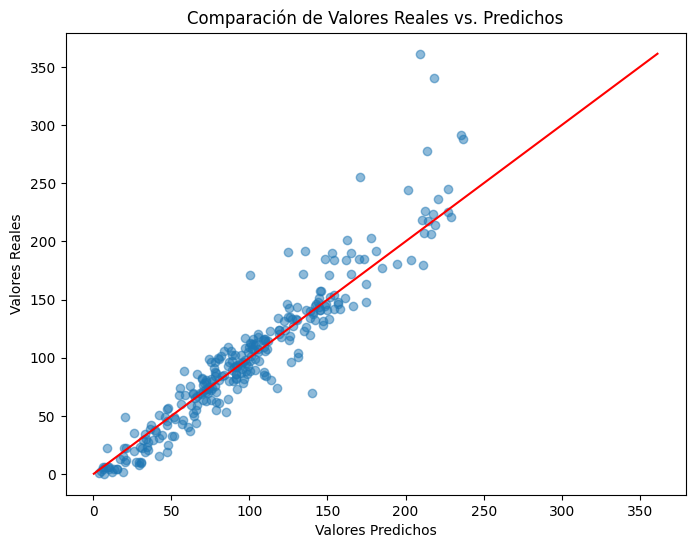

In [30]:
plot_predictions_vs_actual(y_test_original, y_pred)

La recta se ajusta bastante a los valores reales, salvo por algunos outliers que se alejan. Consideramos que es una buena predición y pasamos el modelo a streamlit para que un usuario externo pueda realizar predicciones.